# <center>Тема 3
## <center>Оптимізація нейронних мереж

### <center>Загальні відомості

Часто буває необхідно оптимізувати архітектуру та інші параметри створених нейронних мереж. Завдяки вдалому підбору зовнішніх параметрів мережі можна покращити якість її роботи. Серед підходів, які найчастіше використовуються для оптимізації нейромережевих моделей, можна виділити наступні:

- Підготовка навчальної вибірки
- Дострокова зупинка навчання (early stopping)
- Оптимізація архітектури
- Нормалізація вихідних даних окремих прошарків мережі (Batch normalization)
- Регуляризація нейронів (Dropout)
- Регуляризація ваг (weight regularizers)
- Підбір оптимальних критеріїв якості та метрик
- Підбір характеристик оптимізаторів
- Підбір характеристик ініціалізації ваг (weight initializers)

### <center>Підготовка навчальної вибірки

Розглянемо приклад підготовки даних. Необхідно створити нейронну мережу для класифікації деяких осіб за рівнем доходу. Класів всього два: дохід більше 50 тис. у.о. (income_>50K == 1) та менше 50 тис. у.о. (income_>50K == 0). Для кожної особи є набір характеристик, за якими пропонується визначити рівень доходів (більше 50 тис. або менше). Всі особливості змінних у данних необхідно врахувати у подальшому аналізі.

Перш за все, імпортуємо необхідні модулі.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Наступний код тільки для старих відеокарт (щоб працювало без помилок)

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Завантажуємо дані та переглянемо заголовок таблиці.

In [9]:
data = pd.read_csv("C:/Drive/ІІС/Datasets/income.csv")
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


Як бачимо, характеристики об'єктів в наборі даних можуть бути як числовими (загальний капітал, кількість робочих годин за тиждень, рівень витрат тощо), так і рядковими (професія, сімейний стан, стать тощо).

Переглянемо загальну інформацію про набір даних.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   fnlwgt           43957 non-null  int64 
 3   education        43957 non-null  object
 4   educational-num  43957 non-null  int64 
 5   marital-status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital-gain     43957 non-null  int64 
 11  capital-loss     43957 non-null  int64 
 12  hours-per-week   43957 non-null  int64 
 13  native-country   43194 non-null  object
 14  income_>50K      43957 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.0+ MB


Бачимо, що всього в наборі є дані про 43957 об'єктів (осіб). Окрім того, якщо подивимось уважно, то деякі об'єкти мають пропущені характеристики (число ненульових записів в стовпці не співпадає з загальною кількістю об'єктів).

Відповідно, дізнаємось кількість пропущених значень для кожної характеристики.

In [10]:
data.isnull().sum()

age                   0
workclass          2498
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      763
income_>50K           0
dtype: int64

Як бачимо, пропущені значення є в стопцях *workclass*, *occupation* та *native-country*. Оскільки кожен рядок таблиці являє собою окрему людину, ми не можемо просто взяти і замінити пропущені дані нулями або середніми значеннями. Тому єдиний варіант - прибрати з таблиці записи із пропущеними даними.

In [19]:
clear_data = data.dropna(subset=["workclass", "occupation", "native-country"])
clear_data.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income_>50K        0
dtype: int64

Тепер пропущених даних немає - можна продовжувати роботу.

Перевіряємо, наскільки збалансована кількість зразків кожного класу. В ідеальному випадку, доля зразків кожного класу має бути приблизно однаковою.

In [20]:
clear_data['income_>50K'].value_counts(normalize=True)

0    0.752204
1    0.247796
Name: income_>50K, dtype: float64

Як бачимо, кількість об'єктів кожного класу незбалансована. Це може призвести до того, що мережа під час навчання значно більше "уваги" приділятиме об'єктам того класу, зразків якого більше. За такої незбалансованості навіть може виникнути ситуація, коли до навчальної вибірки не потрапить жодного зразка класу, об'єктів якого менше. З цим треба щось робити.

#### <center>Балансування вибірки

Існують різні підходи до виправлення балансу між класами. Наприклад, можна ввести так звану "вагу класу" - коефіцієнти для кожного класу, які визначатимуть ціну помилки. Ціна помилки для класу, зразків якого в навчальних даних менше, буде більшою. Відповідно, такі зразки будуть сильніше впливати на критерій якості, що змусить мережу більше уваги приділяти саме цим зразкам. Однак, це призведе до розширення діапазону значень функції помилки. Деякі оптимізатори, величина кроку яких залежить від величини градієнту (наприклад, стандартний SGD), можуть спрацювати некоректно. 

Детальніше з використанням зважених класів можна ознайомитись за посиланням: 
- https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

У подальшому ми будемо використовувати більш прості і очевидні підходи, такі як:
- штучне збальшення кількості зразків (oversampling) класу, об'єктів якого менше у вибірці; 
- штучне зменшення (undersampling) кількості зразків класу, об'єктів якого більше у вибірці.

Коли який підхід використовувати?
- Якщо загальна кількість зразків "пригніченого" класу невелика (до 200-300), то використовуємо oversampling - копіюємо існуючі зразки стільки разів, скільки потрібно для зрівняння з "домінуючим" класом.
- Якщо кількість зразків "пригніченого" класу достатня (від 300 і більше), можна видалити потрібну кількість випадкових об'єктів "домінуючого" класу для виправлення балансу. 

Подивимось, скільки у нас зразків кожного класу в абсолютній величині.

In [21]:
clear_data['income_>50K'].value_counts()

0    30635
1    10092
Name: income_>50K, dtype: int64

Зразків класу 1 в три рази менше, ніж класу 0, але достатньо для застосування підходу undersampling. Зробимо це.

Створимо два набори даних (по одному для кожного класу). В перший набір запишемо лише зразки класу 0, в другий - класу 1. Під час формування набору зразків класу 0 вкажемо, що з початкового набору необхідно взяти випадкові 10500 об'єктів, що приблизно буде дорівнювати кількості зразків у класі 1. Потім об'єднаємо ці два набори в один.

In [26]:
# Undersampling
class0 = clear_data[clear_data['income_>50K']==0].sample(n=10500)
class1 = clear_data[clear_data['income_>50K']==1]

balanced_data = pd.concat([class0,class1])
balanced_data['income_>50K'].value_counts(normalize=True)

0    0.509907
1    0.490093
Name: income_>50K, dtype: float64

Тепер кількість зразків в обох класах збалансована.

Якби ми використовували підхід oversampling, потрібно було б виконати аналогічні операції, але зкопіювати набір зразків класу 1 три рази. Приклад коду наведено далі.

In [25]:
# Oversampling
'''
class0 = clear_data[clear_data['income_>50K']==0]
class1 = clear_data[clear_data['income_>50K']==1]
class1 = pd.concat([class1]*3)

balanced_data = pd.concat([class0,class1])
balanced_data['income_>50K'].value_counts(normalize=True)
'''

0    0.502947
1    0.497053
Name: income_>50K, dtype: float64

#### <center>Факторизація

Як ми вже з'ясували, в наборі даних деякі змінні представлені у вигляді рядків. Подивимось знову на заголовок таблиці.

In [27]:
balanced_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
224,60,Private,167670,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,35,United-States,0
9419,59,Private,113838,Bachelors,13,Widowed,Prof-specialty,Not-in-family,White,Female,4650,0,37,United-States,0
36762,43,Private,233851,Bachelors,13,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
23171,27,Self-emp-not-inc,334132,Assoc-acdm,12,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,78,United-States,0
16259,34,Private,299383,HS-grad,9,Never-married,Craft-repair,Not-in-family,Black,Male,0,0,40,United-States,0


Щоб перетворити рядкові дані на числові, використовується операція **факторизації**. Факторизація замінює однакові слова або словосполучення відповідними чисельними значеннями. Таким чином, характеристика об'єкту стає *фактором*, який може бути врахованим математично.

В Pandas з цією метою використовується функція `factorize()`, яку необхідно застосувати для кожного стовпця з текстовими змінними. В нашому випадку, факторизувати необхідно дані у стовпцях *workclass, education, marital-status, occupation,	relationship, race, gender, native-country*. Зробимо це за допомогою наступного коду.

In [31]:
to_factor = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

factor_data = balanced_data.copy()
factor_data[to_factor] = factor_data[to_factor].apply(lambda col: pd.factorize(col, sort=True)[0])
factor_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
224,60,2,167670,9,13,2,9,0,4,1,0,0,35,37,0
9419,59,2,113838,9,13,6,9,1,4,0,4650,0,37,37,0
36762,43,2,233851,9,13,0,0,1,4,0,0,0,40,37,0
23171,27,4,334132,7,12,4,9,1,4,0,0,0,78,37,0
16259,34,2,299383,11,9,4,2,1,2,1,0,0,40,37,0


Однак, якщо ми подивимось уважніше, в стовпці *educational-num* вже містяться факторизовані дані про освіту особи. Відповідно, стовпець *educational-num* та факторизований нами стовпець *education* по суті дублюють один одного. Іншими словами, вони є **колінеарними**. Тому один із цих стовпців можна взагалі прибрати з даних.

In [33]:
final_data = factor_data.drop('education', axis = 1)
final_data.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
224,60,2,167670,13,2,9,0,4,1,0,0,35,37,0
9419,59,2,113838,13,6,9,1,4,0,4650,0,37,37,0
36762,43,2,233851,13,0,0,1,4,0,0,0,40,37,0
23171,27,4,334132,12,4,9,1,4,0,0,0,78,37,0
16259,34,2,299383,9,4,2,1,2,1,0,0,40,37,0


Класи збалансовані, текстові змінні факторизовані, пропущені значення та колінеарні змінні видалені. Тепер можна створити і навчити нейронну мережу за стандартною процедурою.

In [34]:
Y = pd.get_dummies(final_data['income_>50K'], prefix='Class')
X = final_data.drop(['income_>50K'], axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train -= mean
X_train /= std
X_test -= mean
X_test /= std

In [36]:
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
history = model.fit(X_train, Y_train, epochs=30, validation_split=0.15, batch_size=20)

loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 14877 samples, validate on 2626 samples
Epoch 1/30
14877/14877 [==============================] - 3s 182us/step - loss: 0.5293 - accuracy: 0.7364 - val_loss: 0.4578 - val_accuracy: 0.7768
Epoch 2/30
14877/14877 [==============================] - 2s 155us/step - loss: 0.4382 - accuracy: 0.7872 - val_loss: 0.4291 - val_accuracy: 0.8012
Epoch 3/30
14877/14877 [==============================] - 2s 145us/step - loss: 0.4148 - accuracy: 0.8049 - val_loss: 0.4134 - val_accuracy: 0.8111
Epoch 4/30
14877/14877 [==============================] - 2s 144us/step - loss: 0.4039 - accuracy: 0.8100 - val_loss: 0.4062 - val_accuracy: 0.8165
Epoch 5/30
14877/14877 [==============================] - 2s 145us/step - loss: 0.3994 - accuracy: 0.8119 - val_loss: 0.4043 - val_accuracy: 0.8206
Epoch 6/30
14877/14877 [==============================] - 2s 144us/step - loss: 0.3967 - accuracy: 0.8125 - val_loss: 0.4044 - val_accuracy: 0.8165
Epoch 7/30
14877/14877 [==============================] - 2s 14

### <center>Регуляризація

**Регуляризація** - комплекс дій, спрямованих на уникнення перенавчання мережі. У випадку використання регуляризації модель навмисно спрощують під час навчання або обмежують її параметри, накладаючи деякі штрафи за перенавчання. Це дозволяє покращити якість навчання та пришвидшити збіжність оптимізатора. Як наслідок, мережа буде швидше навчатись та більш якісно апроксимувати дані. Особливо помітним вплив регуляризації є у навчанні глибинний мереж з десятками і сотнями прошарків, тоді як більш поверхневі моделі самі по собі є достатньо простими для уникнення перенавчання. Однак, іноді все ж вдається на декілька відсотків підвищити показники якості роботи нейромережі.

Для розгляду різноманітних підходів до регуляризації, повернемось до набору даних з класифікацією мобільних телефонів за ціновими діапазонами.

In [6]:
data = pd.read_csv("D:/Drive/ІІС/Datasets/Classification/phones_price.csv")
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
X = data.drop('price_range', axis = 1)
Y = pd.get_dummies(data.price_range, prefix='Price range')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train -= mean
X_train /= std
X_test -= mean
X_test /= std

In [8]:
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(5, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16)
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 0s 257us/step - loss: 1.3842 - accuracy: 0.2803 - val_loss: 1.3206 - val_accuracy: 0.3529
Epoch 2/50
1445/1445 [==============================] - 0s 185us/step - loss: 1.3162 - accuracy: 0.3315 - val_loss: 1.2721 - val_accuracy: 0.3882
Epoch 3/50
1445/1445 [==============================] - 0s 185us/step - loss: 1.2525 - accuracy: 0.4249 - val_loss: 1.2161 - val_accuracy: 0.4627
Epoch 4/50
1445/1445 [==============================] - 0s 180us/step - loss: 1.1756 - accuracy: 0.4907 - val_loss: 1.1390 - val_accuracy: 0.5373
Epoch 5/50
1445/1445 [==============================] - 0s 186us/step - loss: 1.0916 - accuracy: 0.5315 - val_loss: 1.0702 - val_accuracy: 0.5804
Epoch 6/50
1445/1445 [==============================] - 0s 179us/step - loss: 1.0219 - accuracy: 0.5675 - val_loss: 1.0130 - val_accuracy: 0.6078
Epoch 7/50
1445/1445 [==============================] - 0s 187us/step - loss:

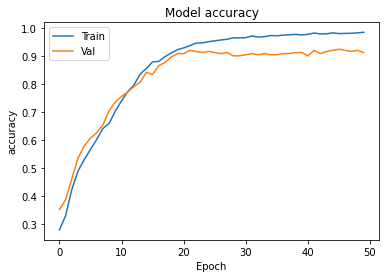

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Як бачимо, приблизно після 20 епохи почалося перенавчення мережі: accuracy на валідаційній множині почала знижуватись (хоча потім і відновила своє середнє значення). Accuracy на тестовій множині склала 88,6%. Відповідно, спробуємо застосувати різні підходи до регуляризації для виправлення даної ситуації і покращення якості роботи мережі.

#### <center>Дострокова зупинка навчання (early stopping)

Keras дозволяє відслідковувати величину зміни критерію якості або метрики під час навчання. Якщо критерій якості не буде покращуватись декілька епох поспіль, існує можливість автоматично зупинити навчання. Це не дозволить мережі продовжувати підлаштовуватись під особливості навчальної вибірки, коли потрібна якість уже досягнута.
- Детальніше: https://keras.io/api/callbacks/early_stopping/

Як видно з документації, для реалізації цього методу використовується клас *EarlyStopping*. Ми повинні створити його екземпляр та вказати посилання на цей об'єкт в якості функції зворотного виклику для метода `model.fit()`. Основні параметри *EarlyStopping*, які нам знадобляться:
- `monitor` - критерій якості або метрика, яку потрібно відслідковувати
- `patience` - кількість епох без покращення результату, після яких навчання буде зупинено.

Використаємо цей підхід. Відслідковувати будемо метрику Accurace на валідаційній множині.

In [59]:
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [72]:
model2 = Sequential()
model2.add(Dense(20, input_dim=X_train.shape[1], activation="relu"))
model2.add(Dense(5, activation="relu"))
model2.add(Dense(4, activation="softmax"))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
# Використовуємо callbacks=[early]
history2 = model2.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16, callbacks=[early]) 

loss, accuracy = model2.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 0s 255us/step - loss: 1.4545 - accuracy: 0.2740 - val_loss: 1.3515 - val_accuracy: 0.3294
Epoch 2/50
1445/1445 [==============================] - 0s 187us/step - loss: 1.3664 - accuracy: 0.3370 - val_loss: 1.3036 - val_accuracy: 0.3490
Epoch 3/50
1445/1445 [==============================] - 0s 180us/step - loss: 1.3032 - accuracy: 0.3882 - val_loss: 1.2536 - val_accuracy: 0.3647
Epoch 4/50
1445/1445 [==============================] - 0s 176us/step - loss: 1.2294 - accuracy: 0.4408 - val_loss: 1.1809 - val_accuracy: 0.4314
Epoch 5/50
1445/1445 [==============================] - 0s 178us/step - loss: 1.1304 - accuracy: 0.4962 - val_loss: 1.0825 - val_accuracy: 0.4902
Epoch 6/50
1445/1445 [==============================] - 0s 199us/step - loss: 1.0078 - accuracy: 0.5592 - val_loss: 0.9690 - val_accuracy: 0.5216
Epoch 7/50
1445/1445 [==============================] - 0s 196us/step - loss:

Як бачимо, спрацював механізм early stopping, і навчання автоматично перервалось на 29 епосі. На тестовій множині ми отримали долю правильних відповідей 91,3%. Подивимось на графік навчання.

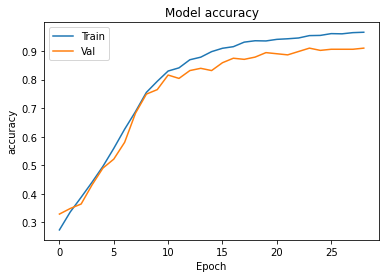

In [74]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Перенавчання немає.

#### <center>Оптимізація архітектури

Іноді початково обрана архітектура мережі є занадто складною, що також може призводити до перенавчання. В такому випадку, доцільно зменшити складність мережі, відповідним чином змінивши кількість прошарків або нейронів у них.

Приберемо другий прихований прошарок з нашої мережі, а також зменшимо кількість нейронів у першому до 6. Цього буде достатньо для вирішення поставленого завдання.

In [75]:
model3 = Sequential()
model3.add(Dense(6, input_dim=X_train.shape[1], activation="relu"))
model3.add(Dense(4, activation="softmax"))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16) 

loss, accuracy = model3.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 0s 237us/step - loss: 1.5003 - accuracy: 0.2948 - val_loss: 1.5053 - val_accuracy: 0.2667
Epoch 2/50
1445/1445 [==============================] - 0s 178us/step - loss: 1.4122 - accuracy: 0.3260 - val_loss: 1.4386 - val_accuracy: 0.3020
Epoch 3/50
1445/1445 [==============================] - 0s 165us/step - loss: 1.3521 - accuracy: 0.3488 - val_loss: 1.3864 - val_accuracy: 0.3412
Epoch 4/50
1445/1445 [==============================] - 0s 159us/step - loss: 1.2971 - accuracy: 0.3779 - val_loss: 1.3326 - val_accuracy: 0.3569
Epoch 5/50
1445/1445 [==============================] - 0s 163us/step - loss: 1.2378 - accuracy: 0.4042 - val_loss: 1.2678 - val_accuracy: 0.3647
Epoch 6/50
1445/1445 [==============================] - 0s 168us/step - loss: 1.1671 - accuracy: 0.4519 - val_loss: 1.1889 - val_accuracy: 0.4196
Epoch 7/50
1445/1445 [==============================] - 0s 169us/step - loss:

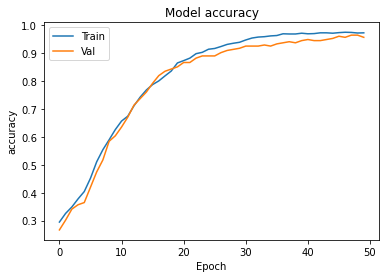

In [76]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Як бачимо, для навчання мережі знадобилося більше ітерацій, але водночас якість суттєво зросла до значення accuracy майже 94,5% на тестовій множині. Перенавчання немає.

#### <center>Batch normalization

Використання прошарку Batch normalization дозволяє пришвидшити навчання та полегшити мережі пошук необхідних ознак. Математичне обгрунтування необхідності використання такого прошарку існує, але його ефективність на практиці часто ставиться під сумнів. Втім, Batch normalization все одно застосовують. 
- Документація в Keras: https://keras.io/api/layers/normalization_layers/batch_normalization/

Прошарок Batch normalization нормалізує вхідні дані для наступного прошарку. Для цього значення по кожному із входів прошарку стандартизуються методом приведення їх до нульового середнього та одиничної дисперсії. Для обчислення необхідних величин використовуються дані за один батч (міні-батч).

Використаємо Batch normalization у комбінації зі спрощеною архітектурою.

In [80]:
from tensorflow.keras.layers import BatchNormalization

model4 = Sequential()
model4.add(Dense(6, input_dim=X_train.shape[1], activation="relu"))
model4.add(BatchNormalization())
model4.add(Dense(4, activation="softmax"))

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history4 = model4.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16) 

loss, accuracy = model4.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 1s 370us/step - loss: 1.6787 - accuracy: 0.2325 - val_loss: 1.4582 - val_accuracy: 0.2980
Epoch 2/50
1445/1445 [==============================] - 0s 231us/step - loss: 1.4983 - accuracy: 0.2865 - val_loss: 1.3770 - val_accuracy: 0.3765
Epoch 3/50
1445/1445 [==============================] - 0s 228us/step - loss: 1.3761 - accuracy: 0.3315 - val_loss: 1.2973 - val_accuracy: 0.4000
Epoch 4/50
1445/1445 [==============================] - 0s 227us/step - loss: 1.2783 - accuracy: 0.4028 - val_loss: 1.2078 - val_accuracy: 0.4824
Epoch 5/50
1445/1445 [==============================] - 0s 231us/step - loss: 1.1903 - accuracy: 0.4561 - val_loss: 1.1183 - val_accuracy: 0.5255
Epoch 6/50
1445/1445 [==============================] - 0s 226us/step - loss: 1.0811 - accuracy: 0.5343 - val_loss: 1.0215 - val_accuracy: 0.5843
Epoch 7/50
1445/1445 [==============================] - 0s 228us/step - loss:

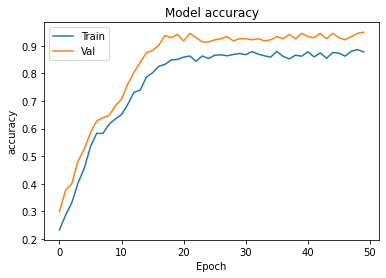

In [81]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Значення accuracy склало 95,6% на тестовій множині. Перенавчання немає.

На графіку можна помітити цікавий ефект - точність на валідаційній множині вище, ніж на навчальній. Це нормально, і вказує на те, що під час навчання використовувалась регуляризація.

#### <center>Dropout

Прошарок Dropout дозволяє уникнути перенавчання шляхом відключення певної кількості випадкових нейронів попереднього прошарку. Під "відключенням" мається на увазі заміна їх вихідних значень на 0. Таким чином, під час навчанння мережа гірше запам'ятовує конкретні навчальні зразки та краще їх узагальнює, виявляючи найбільш значущі взаємозв'язки у даних.

- Документація: https://keras.io/api/layers/regularization_layers/dropout/

Головним параметром прошарку Dropout є `rate` - доля нейронів, які необхідно відключити.

Dropout зазвичай застосовується у випадках, коли прошарок містить декілька десятків і більше нейронів. Однак, з навчальною метою, використаємо його для нашої моделі.

In [10]:
from tensorflow.keras.layers import Dropout

model5 = Sequential()
model5.add(Dense(6, input_dim=X_train.shape[1], activation="relu"))
model5.add(Dropout(0.2))
model5.add(Dense(4, activation="softmax"))

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history5 = model5.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16) 

loss, accuracy = model5.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 0s 287us/step - loss: 1.6374 - accuracy: 0.2360 - val_loss: 1.5357 - val_accuracy: 0.2471
Epoch 2/50
1445/1445 [==============================] - 0s 203us/step - loss: 1.4873 - accuracy: 0.2879 - val_loss: 1.4358 - val_accuracy: 0.2706
Epoch 3/50
1445/1445 [==============================] - 0s 171us/step - loss: 1.3809 - accuracy: 0.3384 - val_loss: 1.3656 - val_accuracy: 0.3373
Epoch 4/50
1445/1445 [==============================] - 0s 172us/step - loss: 1.3374 - accuracy: 0.3689 - val_loss: 1.2944 - val_accuracy: 0.3922
Epoch 5/50
1445/1445 [==============================] - 0s 168us/step - loss: 1.2744 - accuracy: 0.4090 - val_loss: 1.2246 - val_accuracy: 0.4431
Epoch 6/50
1445/1445 [==============================] - 0s 167us/step - loss: 1.1988 - accuracy: 0.4713 - val_loss: 1.1543 - val_accuracy: 0.5176
Epoch 7/50
1445/1445 [==============================] - 0s 168us/step - loss:

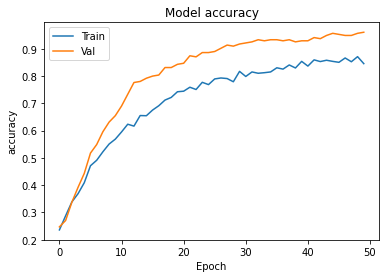

In [11]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Значення accuracy склало 94,6% на тестовій множині. Перенавчання немає. На графіку знову видно ефект регуляризації - точність на валідаційній множині вище, ніж на навчальній. У випадку Dropout це легко пояснити - під час навчання деякі нейрони вимикаються, і модель працює у спрощеному вигляді. Але під час валідаціїї прошарок Dropout не використовується, тому нейронна мережа виконує задачу зі своєю повною потужністю, що призводить до зменшення помилки.

#### <center>Регуляризація ваг (weight regularizers)

Встановлено, що великі значення ваг призводять до перенавчання. Це пояснюється тим, що такі значення "перетягують на себе увагу" мережі, водночас інші ознаки потенційно важливі ознаки будуть ігноруватись. Чим більші значення ваг, тим більш нелінійною буде розділяюча функція (правило), яку шукає мережа під час навчання. Тут можна провести аналогію з апроксимацією поліномом - чим вище степінь полінома, тим біль нелінійною є апроксимуюча функція.

Щоб уникнути перенавчання внаслідок завеликих значень деяких ваг, використовуються так звані регуляризаційні доданки до значення критерію якості. Основні їх види такі:
- L1-регуляризація - під час розрахунку функції втрат до її значення додається зважена сума модулів синаптичних ваг мережі.
- L2-регуляризація - те саме, але додається зважена сума квадратів ваг мережі (використовується частіше).
- L1_L2-регуляризація - комбінація перших двох.

Додавання регуляризаційного доданку до значення функції втрат грає роль штрафу. Чим більше значення цього доданку (чим вище сума ваг), тим вищим буде значення функції втрат. Відповідно, щоб це значення зменшити, оптимізатор буде зменшувати ваги.

Регуляризація може застосовуватись як до основних ваг (kernel regularizer), так і для ваг зміщень (вільних членів) мережі (bias regularizer).
- Детальніше в документації: https://keras.io/api/layers/regularizers/

Застосуємо L2-регуляризацію для нашої моделі. Для цього необхідний вид регуляризації вказується як аргумент під час створення прошарку. 

In [12]:
model6 = Sequential()
model6.add(Dense(6, input_dim=X_train.shape[1], activation="relu", kernel_regularizer='l2'))
model6.add(Dense(4, activation="softmax", kernel_regularizer='l2'))

model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history6 = model6.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16) 

loss, accuracy = model6.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 0s 243us/step - loss: 1.7506 - accuracy: 0.2201 - val_loss: 1.6760 - val_accuracy: 0.2549
Epoch 2/50
1445/1445 [==============================] - 0s 169us/step - loss: 1.6007 - accuracy: 0.2464 - val_loss: 1.5548 - val_accuracy: 0.2902
Epoch 3/50
1445/1445 [==============================] - 0s 158us/step - loss: 1.5076 - accuracy: 0.2830 - val_loss: 1.4683 - val_accuracy: 0.3333
Epoch 4/50
1445/1445 [==============================] - 0s 156us/step - loss: 1.4351 - accuracy: 0.3273 - val_loss: 1.3966 - val_accuracy: 0.3686
Epoch 5/50
1445/1445 [==============================] - 0s 160us/step - loss: 1.3668 - accuracy: 0.3917 - val_loss: 1.3256 - val_accuracy: 0.4549
Epoch 6/50
1445/1445 [==============================] - 0s 157us/step - loss: 1.2944 - accuracy: 0.4630 - val_loss: 1.2482 - val_accuracy: 0.4980
Epoch 7/50
1445/1445 [==============================] - 0s 156us/step - loss:

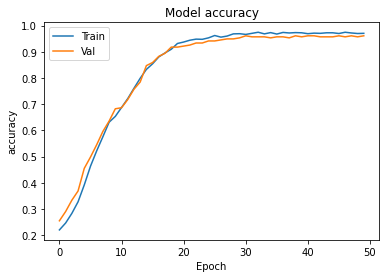

In [13]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Значення accuracy склало 94,9% на тестовій множині. Перенавчання немає.

### <center>Підбір оптимальних критеріїв якості та метрик

Обраний критерій якості напряму впливає на якість роботи нейронної мережі. Адже саме критерій якості оптимізується в ході виконання алгоритму зворотношо поширення помилки. Деякі критерії якості призначені для вирішення лише спеціалізованих задач, деякі є універсальними. Важливо розуміти, який критерій якості потрібно використати в конкретній ситуації.

- Доступні критерії якості в Keras: https://keras.io/api/losses/

Всього критерії якості в Keras діляться на три великі групи:
- Probabilistic losses - функції втрат для вирішення задач класифікації.
- Regression losses - функції втрат для вирішення задач регресії.
- Hinge losses for "maximum-margin" classification - функції втрат для розділових (маржевих) класифікаторів (застосовується рідко).

Якщо вирішується задача класифікації, використовують наступні критерії якості:
- **Binary Crossentropy** - якщо в задачі два класи.
- **Categorical Crossentropy** - якщо в задачі більше двох класів.
- **Sparse Categorical Сrossentropy** - якщо мітки класів представлені звичайними числами (факторами), а не в категоріальному форматі One hot encoding (такий варіант не рекомендується).

Якщо вирішується задача регресії (прогнозування), то зазвичай використовують такі критерії якості:
- **Mean Squared Error** - середня сума квадратів помилок. Нестійка до рідкісних великий за модулем помилок - викидів.
- **Mean Absolute Error** - середня сума модулів помилок. Стійка до викидів, але повільніше збіжність.
- **Mean Absolute Percentage Error** - середня сума модулів помилок у відсотках (простими словами - відносна похибка). Зручна для інтерпретації.
- **Mean Squared Logarithmic Error** - середня сума логарифмів квадратів помилок. Зручна якщо величина змінюється в широкому діапазоні.

На практиці людині важко інтерпретувати значення критеріїв якості. Наприклад, важко зрозуміти, що означає "значення категоріальної крос-ентропії на тестовій множині складає 0,036". Набагато більш легким для сприйняття буде "доля правильних відповідей на тестовій множині складає 98%". Саме тому разом з критеріями якості в Keras застосовуються метрики - показники ефективності нейронної мережі, які людині легше сприйняти і осмислити.

- Доступні метрики в Keras: https://keras.io/api/metrics/

Для задач класифікації найчастіше використовуються:
- **Accuracy** (іноді ще **BinaryAccuracy, CategoricalAccuracy**) - доля правильних відповідей. Застосовується практично завжди.
- **Precision, Recall** - метрики, засновані на підрахунку кількіості помилок I та II роду. Застосовуються у випадку несбалансованих класів.
- **MeanIoU** - застосовується для визначення якості сегментації зображень.

Для задач регресії метриками можуть виступати самі критерії якості. Найчастіше використовуються:
- **Mean Absolute Error** - середня сума модулів помилок. Цю метрику легко інтерпретувати, адже одиниці її вимірювання співпадають з одиницями цілі.
- **Mean Absolute Percentage Error** - середня сума модулів помилок у відсотках.
- **RootMeanSquaredError** - аналог суми квадратів помилок, але додатково береться квадратний корінь. Знову ж таки, щоб узгодити одиниці вимірювання відповіді.

Спробуємо замінити метрику Accuracy на Categorical Accuracy у нашому прикладі. Ця метрика відрізняється від звичайної Accuracy тим, що можна додатково налаштувати деякі її параметри (але ми цього робити не будемо).

In [8]:
model7 = Sequential()
model7.add(Dense(6, input_dim=X_train.shape[1], activation="relu"))
model7.add(Dense(4, activation="softmax"))

model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history7 = model7.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16) 

loss, categ_accuracy = model7.evaluate(X_test, Y_test, verbose=0)
print(loss, categ_accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 0s 226us/step - loss: 1.5554 - categorical_accuracy: 0.2429 - val_loss: 1.3968 - val_categorical_accuracy: 0.2824
Epoch 2/50
1445/1445 [==============================] - 0s 156us/step - loss: 1.3957 - categorical_accuracy: 0.2962 - val_loss: 1.2931 - val_categorical_accuracy: 0.3647
Epoch 3/50
1445/1445 [==============================] - 0s 152us/step - loss: 1.2891 - categorical_accuracy: 0.3779 - val_loss: 1.2167 - val_categorical_accuracy: 0.4078
Epoch 4/50
1445/1445 [==============================] - 0s 156us/step - loss: 1.2061 - categorical_accuracy: 0.4422 - val_loss: 1.1490 - val_categorical_accuracy: 0.5059
Epoch 5/50
1445/1445 [==============================] - 0s 154us/step - loss: 1.1359 - categorical_accuracy: 0.5087 - val_loss: 1.0897 - val_categorical_accuracy: 0.5529
Epoch 6/50
1445/1445 [==============================] - 0s 153us/step - loss: 1.0730 - categorical_accu

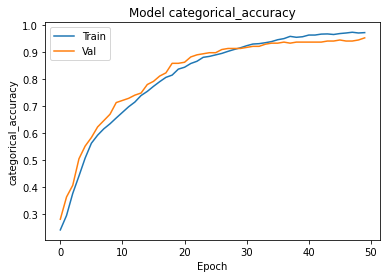

In [9]:
plt.plot(history7.history['categorical_accuracy'])
plt.plot(history7.history['val_categorical_accuracy'])
plt.title('Model categorical_accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Значення категоріальної долі правильних відповідей склало 95,3% на тестовій множині.

### <center>Підбір характеристик оптимізаторів

Не дивлячись на те, що на даний момент найбільш популярним оптимізатором є Adam, іноду буває необхідність замінити його або підлаштувати деякі параметри (наприклад, швидкість навчання learning rate). Для цього можна створити новий екземпляр класу потрібного оптимізатора, і вказати бажані атрибути замість стандартних. Можна навіть створити власний оптимізатор.

- Доступні оптимізатори в Keras: https://keras.io/api/optimizers/

Для того, щоб створити оптимізатор з власними налаштуваннями, необхідно в документації знайти опис відповідного класу оптимізатора та переглянути список доступних атрибутів. 
- Наприклад, опис класу Adam: https://keras.io/api/optimizers/adam/

Використовуючи такий підхід, створимо оптимізатор Adam з нестандартними параметрами (змінимо learning rate) і застосуємо його в нашій моделі.

In [10]:
from tensorflow.keras import optimizers

my_adam = optimizers.Adam(learning_rate=0.01)

model8 = Sequential()
model8.add(Dense(6, input_dim=X_train.shape[1], activation="relu"))
model8.add(Dense(4, activation="softmax"))

model8.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

history8 = model8.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16) 

loss, accuracy = model8.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Epoch 1/50
91/91 [==============================] - 0s 3ms/step - loss: 1.1605 - accuracy: 0.4581 - val_loss: 0.8606 - val_accuracy: 0.5843
Epoch 2/50
91/91 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.7384 - val_loss: 0.5462 - val_accuracy: 0.8118
Epoch 3/50
91/91 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.8581 - val_loss: 0.3843 - val_accuracy: 0.8902
Epoch 4/50
91/91 [==============================] - 0s 2ms/step - loss: 0.3121 - accuracy: 0.9024 - val_loss: 0.2710 - val_accuracy: 0.9373
Epoch 5/50
91/91 [==============================] - 0s 2ms/step - loss: 0.2327 - accuracy: 0.9446 - val_loss: 0.2095 - val_accuracy: 0.9451
Epoch 6/50
91/91 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.9557 - val_loss: 0.1923 - val_accuracy: 0.9490
Epoch 7/50
91/91 [==============================] - 0s 2ms/step - loss: 0.1634 - accuracy: 0.9557 - val_loss: 0.1628 - val_accuracy: 0.9647
Epoch 8/50
91/91 [==

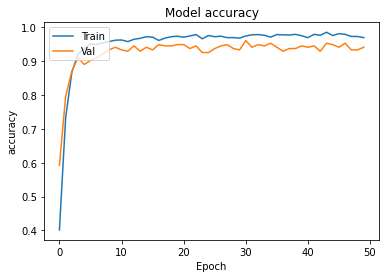

In [17]:
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Як бачимо, збільшивши швидкість навчання, оптимазітор швидше знайшов мінімум. Але при цьому є ризик пропустити інший мінімум, до чого може призвести завеликий крок навчання - оптимізатор просто "перестрибне" необхідну область.

Окрім модифікацій параметрів оптимізатора Adam, можна для порівняння створити інший оптимізатор з використанням класичного методу градієнтного спуску з поправкою (моментом) Нестерова.

In [24]:
from tensorflow.keras import optimizers

my_SGD = optimizers.SGD(learning_rate=0.001, momentum=0.8, nesterov=True)

model9 = Sequential()
model9.add(Dense(6, input_dim=X_train.shape[1], activation="relu"))
model9.add(Dense(4, activation="softmax"))

model9.compile(optimizer=my_SGD, loss='categorical_crossentropy', metrics=['accuracy'])

history9 = model9.fit(X_train, Y_train, epochs=100, validation_split=0.15, batch_size=16) 

loss, accuracy = model9.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/100
1445/1445 [==============================] - 0s 176us/step - loss: 1.5448 - accuracy: 0.3149 - val_loss: 1.4357 - val_accuracy: 0.3725
Epoch 2/100
1445/1445 [==============================] - 0s 129us/step - loss: 1.4731 - accuracy: 0.3280 - val_loss: 1.3876 - val_accuracy: 0.3961
Epoch 3/100
1445/1445 [==============================] - 0s 130us/step - loss: 1.4253 - accuracy: 0.3433 - val_loss: 1.3520 - val_accuracy: 0.4078
Epoch 4/100
1445/1445 [==============================] - 0s 133us/step - loss: 1.3889 - accuracy: 0.3592 - val_loss: 1.3223 - val_accuracy: 0.4353
Epoch 5/100
1445/1445 [==============================] - 0s 129us/step - loss: 1.3581 - accuracy: 0.3792 - val_loss: 1.2952 - val_accuracy: 0.4353
Epoch 6/100
1445/1445 [==============================] - 0s 129us/step - loss: 1.3302 - accuracy: 0.3979 - val_loss: 1.2682 - val_accuracy: 0.4667
Epoch 7/100
1445/1445 [==============================] - 0s 129us/step 

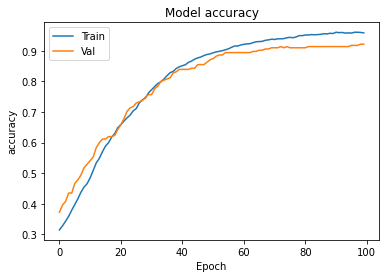

In [25]:
plt.plot(history9.history['accuracy'])
plt.plot(history9.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Як можна побачити, оптимізатору SGD знадобилось більше ітерацій навчання, щоб знайти мінімум. Водночас, показники якості роботи мережі суттєво не покращились. Accuracy на тестовій множині склала майже 94%. Висновок - змінюємо параметри оптимізатора або використовуємо Adam.

### <center>Підбір характеристик ініціалізації ваг (weight initializers)

Ми вже знаємо, що перед початком навчання мережі необхідно задати початкові значення ваг - ініціалізувати їх. Але яким чином провести цю ініціалізацію? Варіантів багато.

- Документація: https://keras.io/api/layers/initializers/

Найчастіше ваги ініціалізуються випадковими маленькими числами. Ми можемо задати закон розподілу цих чисел або взагалі провести ініціалізацію константами (тільки для ваг зміщень bias!). Keras пропонує нам наступні варіанти:

- Random Normal - ініціалізація за нормальним законом розподілу. Використовується за замовчуванням.
- Random Uniform - ініціалізація за рівномірним законом розподілу.
- Truncated Normal - ініціалізація за нормальним законом розподілу, для якого введені граничні значення величин (усічений нормальний закон).
- Zeros - встановити всі початкові ваги в 0. Не сильно зрозуміло, навіщо.
- Ones - встановити всі початкові ваги в 1. Іноді застосовується в мережах LSTM.
- Constant - ініціалізувати константою. Можна використовувати для ініціалізації ваг зміщень. Константа має бути маленьким дійсним числом!

Але найчастіше нестандартна ініціалізація ваг використовується з метою доступу до параметру `seed` - зерна датчику випадкових чисел. Встановивши цей параметр, при кожній реініціалізації (повторному встановленню) початкових значень ваг їх величини будуть однаковими. Таким чином, запам'ятавши значення початкових ваг, можна в будь-який перенавчити мережу для отримання тих самих характеристик її якості (якщо і інші параметри навчання не змінюються). Оскільки початкові значення ваг залишаються однаковими, оптимізатор завжди починає роботу алгоритму з тієї самої початкової точки.

Застосуємо алгоритм ініціалізації ваг нейронів (kernel) Truncated Normal, а ваги зміщень (bias) ініціалізуємо константами. Також задамо параметр `seed` для відтворюваності результатів навчання у разі перезапуску. Ініціалізатори ваг вказуються як атрибути прошарку під час його створення.

In [27]:
from tensorflow.keras import initializers

init = initializers.TruncatedNormal(mean=0., stddev=0.05, seed=12345)
init_b = initializers.Constant(1e-3)

model10 = Sequential()
model10.add(Dense(6, input_dim=X_train.shape[1], activation="relu", kernel_initializer=init, bias_initializer=init_b))
model10.add(Dense(4, activation="softmax", kernel_initializer=init, bias_initializer=init_b))

model10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history10 = model10.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16) 

loss, accuracy = model10.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 0s 211us/step - loss: 1.3841 - accuracy: 0.3176 - val_loss: 1.3755 - val_accuracy: 0.4667
Epoch 2/50
1445/1445 [==============================] - 0s 153us/step - loss: 1.3379 - accuracy: 0.5315 - val_loss: 1.2712 - val_accuracy: 0.5020
Epoch 3/50
1445/1445 [==============================] - 0s 154us/step - loss: 1.1840 - accuracy: 0.4997 - val_loss: 1.0916 - val_accuracy: 0.5098
Epoch 4/50
1445/1445 [==============================] - 0s 149us/step - loss: 1.0286 - accuracy: 0.5080 - val_loss: 0.9620 - val_accuracy: 0.5176
Epoch 5/50
1445/1445 [==============================] - 0s 150us/step - loss: 0.9179 - accuracy: 0.5121 - val_loss: 0.8698 - val_accuracy: 0.5451
Epoch 6/50
1445/1445 [==============================] - 0s 151us/step - loss: 0.8375 - accuracy: 0.5543 - val_loss: 0.7994 - val_accuracy: 0.5922
Epoch 7/50
1445/1445 [==============================] - 0s 151us/step - loss:

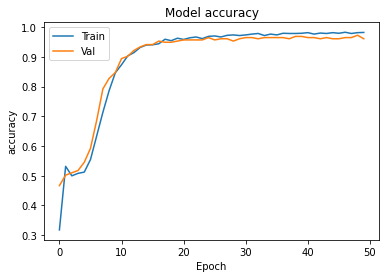

In [28]:
plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Отримали Accuracy на тестовій множині 95,3%. За графіком навчання видно, що на початкових ітераціях оптимізатор знаходився далеко від мінімуму, але зрештою вийшов з цієї ситуації. Це трапилось тому що ініціалізовані значення ваг були підібрані не зовсім вдало.

### <center>Підсумок

Коли який із розглянутих підходів застосовувати - питання без відповіді. Метод проб і помилок. Лише підбором і комбінацією описаних методів можна досягти оптимального результату.

Зазвичай, найбільший вплив на ефективність роботи мережі мають збалансована вибірка, правильно підібрана архітектура, регуляризація ваг та Batch normalization. Часто корисним є Dropout - якщо в мережі багато нейронів і вона має складну архітектуру. Також не потрібно забувати і про early stopping. Спробуємо створити мережу із використанням цих підходів.

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

init = initializers.TruncatedNormal(mean=0., stddev=0.05, seed=98765)
init_b = initializers.Constant(1e-3)

model11 = Sequential()
model11.add(Dense(6, input_dim=X_train.shape[1], activation="relu", kernel_initializer=init, bias_initializer=init_b, kernel_regularizer='l2'))
model11.add(BatchNormalization())
model11.add(Dropout(0.2))
model11.add(Dense(4, activation="softmax", kernel_initializer=init, bias_initializer=init_b, kernel_regularizer='l2'))
model11.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history11 = model11.fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16, callbacks=[early]) 

loss, accuracy = model11.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 1s 404us/step - loss: 1.3525 - accuracy: 0.3889 - val_loss: 1.3643 - val_accuracy: 0.5765
Epoch 2/50
1445/1445 [==============================] - 0s 230us/step - loss: 1.1678 - accuracy: 0.5737 - val_loss: 1.2343 - val_accuracy: 0.5961
Epoch 3/50
1445/1445 [==============================] - 0s 232us/step - loss: 0.9482 - accuracy: 0.6415 - val_loss: 1.0163 - val_accuracy: 0.7294
Epoch 4/50
1445/1445 [==============================] - 0s 235us/step - loss: 0.8165 - accuracy: 0.7107 - val_loss: 0.8009 - val_accuracy: 0.8706
Epoch 5/50
1445/1445 [==============================] - 0s 240us/step - loss: 0.7152 - accuracy: 0.7875 - val_loss: 0.6316 - val_accuracy: 0.8980
Epoch 6/50
1445/1445 [==============================] - 0s 231us/step - loss: 0.6393 - accuracy: 0.8076 - val_loss: 0.5283 - val_accuracy: 0.8980
Epoch 7/50
1445/1445 [==============================] - 0s 233us/step - loss:

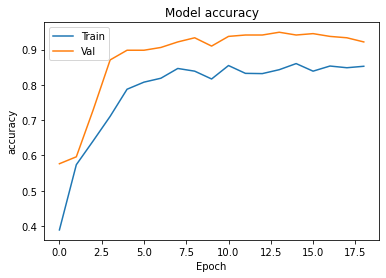

In [33]:
plt.plot(history11.history['accuracy'])
plt.plot(history11.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Отже, в результаті ми отримали показник долі правильних відповідей на тестовій множині у розмірі 96,3%, що є набагато кращим у порівнянні з початковою моделлю (88,6%). Ось так "тюнінгують" нейронні мережі:)

## <center>Навчання пакету моделей

Оскільки кожну нейронну мережу необхідно навчати декілька разів (з метою уникнення локальних мінімумів), корисно робити це в циклі. Будемо створювати одразу кілька моделей, а потом з них обирати найкращу. Далі код без зайвих коментарів.

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

# Вказуємо, скільки моделей ми хочемо навчити
NumberOfModels = 10
# Створюємо заготовки для відповідних списків
Model = []
History = []
Loss = []

# Оголошуємо необхідні налаштування
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)

init = initializers.TruncatedNormal(mean=0., stddev=0.05)
init_b = initializers.Constant(1e-3)

# Власне цикл
for i in range(NumberOfModels):
    Model.append(Sequential())
    Model[i].add(Dense(6, input_dim=X_train.shape[1], activation="relu", kernel_initializer=init, bias_initializer=init_b, kernel_regularizer='l2'))
    Model[i].add(BatchNormalization())
    Model[i].add(Dropout(0.2))
    Model[i].add(Dense(4, activation="softmax", kernel_initializer=init, bias_initializer=init_b, kernel_regularizer='l2'))
    Model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    History.append(Model[i].fit(X_train, Y_train, epochs=50, validation_split=0.15, batch_size=16, callbacks=[early]))
    
    Loss.append(Model[i].evaluate(X_test, Y_test, verbose=0))

# Обираємо найкращу модель за показником Accuracy на тестовій множині
best = max([Loss[i][1] for i in range(NumberOfModels)])
print('Best: ', best)

Train on 1445 samples, validate on 255 samples
Epoch 1/50
1445/1445 [==============================] - 1s 414us/step - loss: 1.3066 - accuracy: 0.4353 - val_loss: 1.3423 - val_accuracy: 0.5176
Epoch 2/50
1445/1445 [==============================] - 0s 238us/step - loss: 1.0320 - accuracy: 0.6062 - val_loss: 1.1641 - val_accuracy: 0.6275
Epoch 3/50
1445/1445 [==============================] - 0s 238us/step - loss: 0.8541 - accuracy: 0.6644 - val_loss: 0.9619 - val_accuracy: 0.8549
Epoch 4/50
1445/1445 [==============================] - 0s 236us/step - loss: 0.7292 - accuracy: 0.7806 - val_loss: 0.7613 - val_accuracy: 0.9137
Epoch 5/50
1445/1445 [==============================] - 0s 234us/step - loss: 0.6366 - accuracy: 0.8374 - val_loss: 0.5983 - val_accuracy: 0.9294
Epoch 6/50
1445/1445 [==============================] - 0s 234us/step - loss: 0.5843 - accuracy: 0.8325 - val_loss: 0.4941 - val_accuracy: 0.9098
Epoch 7/50
1445/1445 [==============================] - 0s 233us/step - loss: